In [50]:
# General
import numpy as np
import matplotlib.pyplot as plt
import time

# Linear regression
import sklearn.linear_model

# CNN
import torch
from torch import nn, cuda
from torch.utils.data import DataLoader, Dataset

In [51]:
digits = np.loadtxt('mfeat-pix.txt', usecols=range(240))

In [52]:
digits.size

480000

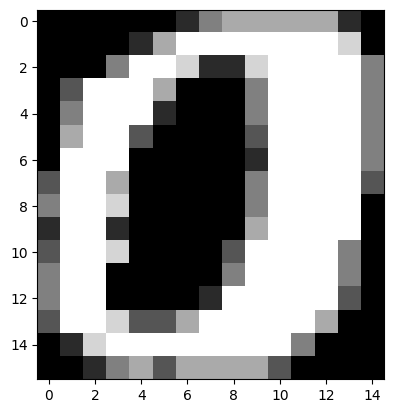

In [53]:
plt.imshow(digits[1].reshape(16,15), cmap='gray')

In [54]:
x_train = np.empty([1000, 240])
y_train = []
x_test = np.empty([1000, 240])
y_test = []
for d in range(10):
    for i in range(100):
        x_train[d*100 + i] = digits[d*200 + i]
        x_test[d*100 + i] = digits[100 + d*200 + i]
    y_train = np.concatenate((y_train, np.full(100, d)))
    y_test = np.concatenate((y_test, np.full(100, d)))

x_train = x_train / x_train.max()
x_test = x_test / x_test.max()

In [55]:
  lr = sklearn.linear_model.LogisticRegression(solver='saga', tol=0.1)
lr = lr.fit(x_train, y_train)

print(f'train: {lr.score(x_train, y_train)}')
print(f'test: {lr.score(x_test, y_test)}')

train: 0.98
test: 0.957


In [56]:
print('Train: X=%s, y=%s' % (x_train.shape, y_train.shape))
print('Train: X=%s, y=%s' % (x_test.shape, y_test.shape))

Train: X=(1000, 240), y=(1000,)
Train: X=(1000, 240), y=(1000,)


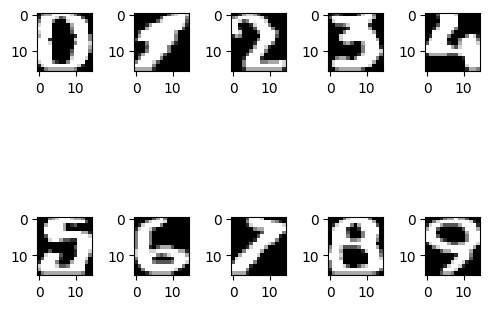

In [57]:
fig, axes = plt.subplots(2, 5, figsize=(5, 5))
for i in range(10):
    row = i // 5
    col = i % 5
    axes[row, col].imshow(x_train[100 * i].reshape(16, 15), cmap='gray')
plt.tight_layout()
plt.show()

In [58]:
#converted to pytorch format
x_train = torch.from_numpy(x_train)
x_test = torch.from_numpy(x_test)
y_train = torch.from_numpy(y_train)
y_test = torch.from_numpy(y_test)

In [59]:
#basic mlp (was used to create CNN, can ignore for now)
class SimpleMLP(torch.nn.Module):
    def __init__(self, size_list):
        super(SimpleMLP, self).__init__()
        self.size_list = size_list
        layers = []
        for i in range(len(size_list) - 2):
            layers.append(torch.nn.Linear(size_list[i], size_list[i+1]))
            layers.append(torch.nn.ReLU())
        layers.append(torch.nn.Linear(size_list[-2], size_list[-1]))
        self.net = torch.nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

In [60]:
#100 percent not expected as some drawings are ambigous, maybe find example of ambigous drawings in the training set.
# .Can do data augmentation, can add features etc. Make sure we know difference between test train and validation.
# Do CNN, could compare a standard MLP with a CNN for extra points. as it isnt clear why CNN is good for the task, so we can investigate this
# cnn good under certain conditions. Need to think how the 2 work. If we know the basic idea which motivates the CNN (find out which tasks CNN makes
# sense for). Note the dataset is very small, overfitting danger is real. If netwrok too big and we don't do careful regularisation we will overfit,
# so we should know how to do this and document this nicely. Document which alphas (and other parameters) we investigated etc, but don't need to say the
# the result for all of them. At the end show the results on the testing data. Shouldn't test it too often on the testing data, as we will get information
# back flow. Shouldn't use testing until the final, use validation to optimise the model until we find the best one and then we use it on the test one.


In [61]:
# Load digits array from file
# File is formatted 200 rows per digit, each row representing a 15x16 grayscale image
digits = np.loadtxt('mfeat-pix.txt', usecols=range(240))

In [62]:
varied_digits = digits.reshape(digits.__len__(), 16, 15) # Temporary placeholder for shifted digits
varied_digits.shape

(2000, 16, 15)

In [63]:
# Split the data in train and test data, 50/50
# TODO Train data is to be split further into train and validate data,
# so we can keep test data in a vault.
# TODO Train data is to be augmented by shifting in the 8 cardinal directions
# so the training set is larger. Left and right are already done above

x_train = np.empty([0, 16, 15])
y_train = np.empty(0)
y_train_one_hot = np.empty([0, 10])
x_test = np.empty([0, 16, 15])
y_test = np.empty(0)
y_test_one_hot = np.empty([0, 10])

varied_digits_per_digit = np.array(np.split(varied_digits, 10))

for d in range(10):
    [d_train, d_test] = np.array(np.split(varied_digits_per_digit[d], 2))
    x_train = np.concatenate((x_train, d_train))
    x_test = np.concatenate((x_test, d_test))
    y_train = np.concatenate((y_train, np.full(d_train.__len__(), d)))
    y_test = np.concatenate((y_test, np.full(d_test.__len__(), d)))

    one_hot = np.zeros(10)
    one_hot[d] = 1
    y_train_one_hot = np.concatenate((y_train_one_hot, np.tile(one_hot, (d_train.__len__(), 1))))
    y_test_one_hot = np.concatenate((y_test_one_hot, np.tile(one_hot, (d_test.__len__(), 1))))

# Normalize the input to be in [0,1]
x_train = x_train / x_train.max()
x_test = x_test / x_test.max()

In [64]:
# Special torch arrays
# Taken from mnist_keras_pytorch.ipynb from tutorial
torch_x_train = torch.from_numpy(x_train).unsqueeze(1)
torch_y_train = torch.from_numpy(y_train)
torch_x_test = torch.from_numpy(x_test).unsqueeze(1)
torch_y_test = torch.from_numpy(y_test)

In [65]:
# NEW split the training data into further training set and validation set -NOT NEEDED as done in kfold
#from sklearn.model_selection import train_test_split

#torch_x_train, torch_x_val, torch_y_train, torch_y_val = train_test_split(torch_x_train, torch_y_train, test_size=0.2, random_state=42)

In [66]:
# Torch datasets
# Taken from mnist_keras_pytorch.ipynb from tutorial
class DigitsDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y

    def __len__(self):
        return len(self.Y)

    def __getitem__(self, index):
        X = self.X[index].float()
        Y = self.Y[index].long()
        return X,Y

train_dataset = DigitsDataset(torch_x_train, torch_y_train)
test_dataset = DigitsDataset(torch_x_test, torch_y_test)
val_dataset = DigitsDataset(torch_x_val, torch_y_val)

In [67]:
# Torch dataloader
# Taken from mnist_keras_pytorch.ipynb from tutorial
if cuda.is_available():
    loader_args = dict(shuffle=True, batch_size=256, num_workers=8, pin_memory=True)
else:
    loader_args = dict(shuffle=True, batch_size=64)

train_loader = DataLoader(train_dataset, **loader_args)
test_loader = DataLoader(test_dataset, **loader_args)
val_loader = DataLoader(val_dataset, **loader_args)

In [68]:
# Taken from mnist_keras_pytorch.ipynb from tutorial
def train_epoch(model, train_loader, criterion, optimizer):
    model.train()

    running_loss = 0.0

    start_time = time.time()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()   # .backward() accumulates gradients
        data = data.to(device)
        target = target.to(device) # all data & model on same device

        outputs = model(data)
        loss = criterion(outputs, target)
        running_loss += loss.item()

        loss.backward()
        optimizer.step()

    end_time = time.time()

    running_loss /= len(train_loader)
    print('Training Loss: ', running_loss, 'Time: ',end_time - start_time, 's')
    return running_loss

In [69]:
# Taken from mnist_keras_pytorch.ipynb from tutorial
def test_model(model, test_loader, criterion):
    with torch.no_grad():
        model.eval()

        running_loss = 0.0
        total_predictions = 0.0
        correct_predictions = 0.0

        for batch_idx, (data, target) in enumerate(test_loader):
            data = data.to(device)
            target = target.to(device)
            outputs = model(data)


            _, predicted = torch.max(outputs.data, 1)
            total_predictions += target.size(0)
            correct_predictions += (predicted == target).sum().item()

            loss = criterion(outputs, target).detach()
            running_loss += loss.item()

        running_loss /= len(test_loader)
        acc = (correct_predictions/total_predictions)*100.0
        print('Testing Loss: ', running_loss)
        print('Testing Accuracy: ', acc, '%')
        return running_loss, acc

In [70]:
def train_model(model, train_loader, test_loader, criterion, optimizer, epochs=10):
    Train_loss = []
    Test_loss = []
    Test_acc = []

    for i in range(epochs):
        train_loss = train_epoch(model, train_loader, criterion, optimizer)
        test_loss, test_acc = test_model(model, test_loader, criterion)
        Train_loss.append(train_loss)
        Test_loss.append(test_loss)
        Test_acc.append(test_acc)
        print('='*20)

    return Train_loss, Test_loss, Test_acc

In [70]:
leNet5 = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, padding=2),
    nn.ReLU(),  # Changed activation function to ReLU
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(in_channels=6, out_channels=16, kernel_size=3),
    nn.ReLU(),  # Changed activation function to ReLU
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(in_features=96, out_features=120),
    nn.ReLU(),  # Changed activation function to ReLU
    nn.Linear(in_features=120, out_features=84),
    nn.ReLU(),  # Changed activation function to ReLU
    nn.Linear(in_features=84, out_features=10)
)

criterion = nn.CrossEntropyLoss()
#optimizer = torch.optim.Adam(leNet5.parameters())
optimizer = torch.optim.SGD(leNet5.parameters(), lr=0.01, momentum=0.9)  # Changed optimizer to SGD with momentum

print(leNet5)

In [71]:
device = torch.device('cuda' if cuda.is_available() else 'cpu')
#leNet5.to(device)

#NEW changed to run on validation set
#train_loss, test_loss, test_acc = train_model(leNet5, train_loader, val_loader, criterion, optimizer, 30)

In [72]:
len(train_index)

800

In [75]:
from sklearn.model_selection import KFold
from sklearn.metrics import precision_score, recall_score, f1_score

# Set the number of folds
k_folds = 5

# Create the KFold object
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

# Lists to store the performance metrics for each fold
fold_train_loss = []
fold_val_loss = []
fold_val_acc = []

fold_precision = []
fold_recall = []
fold_f1 = []


# Iterate over the folds
for fold, (train_index, val_index) in enumerate(kf.split(torch_x_train)):
    print(f"Fold {fold+1}/{k_folds}")

    # Create the train and validation datasets for this fold
    fold_train_dataset = DigitsDataset(torch_x_train[train_index], torch_y_train[train_index])
    fold_val_dataset = DigitsDataset(torch_x_train[val_index], torch_y_train[val_index])

    # Create the train and validation data loaders for this fold
    fold_train_loader = DataLoader(fold_train_dataset, **loader_args)
    fold_val_loader = DataLoader(fold_val_dataset, **loader_args)

    # Create a new instance of the model for each fold
    leNet5 = nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, padding=2),
        nn.ReLU(),
        nn.AvgPool2d(kernel_size=2, stride=2),
        nn.Conv2d(in_channels=6, out_channels=16, kernel_size=3),
        nn.ReLU(),
        nn.AvgPool2d(kernel_size=2, stride=2),
        nn.Flatten(),
        nn.Linear(in_features=96, out_features=120),
        nn.ReLU(),
        nn.Linear(in_features=120, out_features=84),
        nn.ReLU(),
        nn.Linear(in_features=84, out_features=10)
    )

    # Move the model to the device
    leNet5.to(device)

    # Create a new instance of the optimizer for each fold
    optimizer = torch.optim.Adam(leNet5.parameters())

    # Train the model for this fold
    train_loss, val_loss, val_acc = train_model(leNet5, fold_train_loader, fold_val_loader, criterion, optimizer, 30)

    # Store the performance metrics for this fold
    fold_train_loss.append(train_loss)
    fold_val_loss.append(val_loss)
    fold_val_acc.append(val_acc)

        # Compute precision, recall, and F1-score
    with torch.no_grad():
        # Set model to evaluation mode
        leNet5.eval()

        # Lists to store predicted and true labels
        all_predicted = []
        all_true = []

        for images, labels in fold_val_loader:
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass to get predictions
            outputs = leNet5(images)

            # Convert output probabilities to predicted labels
            _, predicted = torch.max(outputs.data, 1)

            # Append predicted and true labels
            all_predicted.extend(predicted.cpu().numpy())
            all_true.extend(labels.cpu().numpy())

        # Compute precision, recall, and F1-score
        precision = precision_score(all_true, all_predicted, average='macro')
        recall = recall_score(all_true, all_predicted, average='macro')
        f1 = f1_score(all_true, all_predicted, average='macro')

        # Store the performance metrics for this fold
        fold_precision.append(precision)
        fold_recall.append(recall)
        fold_f1.append(f1)


Fold 1/5
Training Loss:  2.29584945165194 Time:  0.12433385848999023 s
Testing Loss:  2.2853416204452515
Testing Accuracy:  7.000000000000001 %
Training Loss:  2.241251376958994 Time:  0.1099703311920166 s
Testing Loss:  2.2042715549468994
Testing Accuracy:  17.0 %
Training Loss:  2.0340980749863844 Time:  0.1097416877746582 s
Testing Loss:  1.855877697467804
Testing Accuracy:  43.0 %
Training Loss:  1.5013699256456816 Time:  0.1087346076965332 s
Testing Loss:  1.2990081906318665
Testing Accuracy:  54.50000000000001 %
Training Loss:  0.9625540696657621 Time:  0.11281394958496094 s
Testing Loss:  0.7968358844518661
Testing Accuracy:  69.0 %
Training Loss:  0.706358579488901 Time:  0.11835026741027832 s
Testing Loss:  0.7248979806900024
Testing Accuracy:  75.5 %
Training Loss:  0.5993663026736333 Time:  0.1098027229309082 s
Testing Loss:  0.7218806371092796
Testing Accuracy:  72.0 %
Training Loss:  0.5298262032178732 Time:  0.17517971992492676 s
Testing Loss:  0.8023939207196236
Testing 

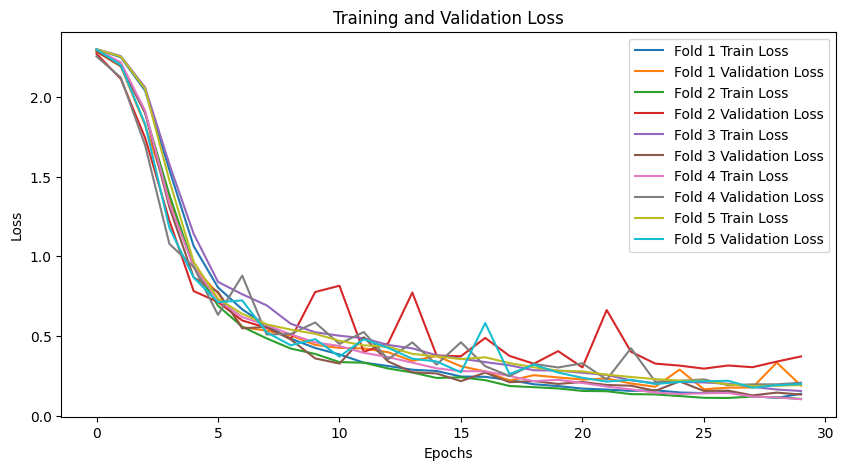

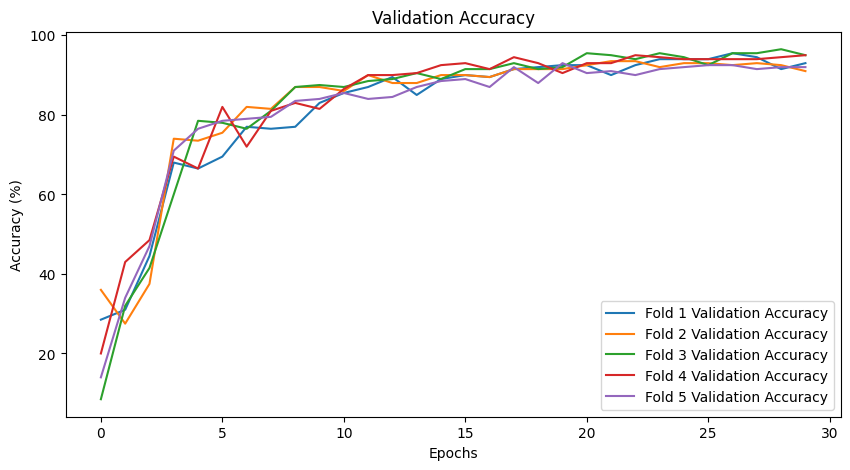

In [74]:
import matplotlib.pyplot as plt

# Plot the training and validation loss for each fold
plt.figure(figsize=(10, 5))
for fold in range(k_folds):
    plt.plot(fold_train_loss[fold], label=f"Fold {fold+1} Train Loss")
    plt.plot(fold_val_loss[fold], label=f"Fold {fold+1} Validation Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Plot the validation accuracy for each fold
plt.figure(figsize=(10, 5))
for fold in range(k_folds):
    plt.plot(fold_val_acc[fold], label=f"Fold {fold+1} Validation Accuracy")
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy')
plt.legend()
plt.show()

In [85]:
#table of the scores:
import pandas as pd

# Create a dictionary to store the scores for each fold
fold_scores = {'Fold': [], 'Precision': [], 'Recall': [], 'F1-Score': []}

# Populate the dictionary with the scores for each fold
for fold in range(k_folds):
    fold_scores['Fold'].append(fold + 1)
    fold_scores['Precision'].append(fold_precision[fold])
    fold_scores['Recall'].append(fold_recall[fold])
    fold_scores['F1-Score'].append(fold_f1[fold])

# Create a DataFrame from the fold_scores dictionary
scores_df = pd.DataFrame(fold_scores)

# Display the table of scores
print(scores_df)

   Fold  Precision    Recall  F1-Score
0     1   0.908631  0.916835  0.909244
1     2   0.897553  0.898623  0.896571
2     3   0.940361  0.939754  0.938204
3     4   0.942757  0.941191  0.941514
4     5   0.960577  0.962389  0.960899
